## Resumen del Proyecto

Este notebook presenta un análisis de series de tiempo sobre las temperaturas máximas promedio anuales en los departamentos de la región Caribe de Colombia, con base en un conjunto de datos históricos climáticos.

### Propósito

Evaluar la evolución de la temperatura máxima promedio por departamento y aplicar métodos numéricos de ajuste polinómico para identificar posibles tendencias.

###  Datos Utilizados

- **Fuente:** Base de datos climáticos históricos por departamento (formato `.csv`).
- **Periodo:** Años comprendidos entre 2005 y 2025.
- **Variables relevantes:** Año, Departamento, Temperatura máxima promedio (°C).

###  Implementación

- **Limpieza y filtrado de datos:** Se seleccionaron únicamente los departamentos de la región Caribe.
- **Visualización:** Se graficaron los datos por departamento.
- **Método numérico aplicado:** Ajuste polinómico por mínimos cuadrados (grados 2, 3 y 4).
- **Evaluación del modelo:** Se calculó el coeficiente de determinación \( R^2 \) para determinar la calidad de cada ajuste.
- **Comparación de resultados:** Se identificó el mejor grado de ajuste para cada departamento y se visualizaron en gráficos individuales y múltiples (subplots).
- **Análisis crítico:** Se discutieron los resultados obtenidos, su validez y limitaciones para predicción.



---


## Carga Inicial de Datos

In [1]:
import pandas as pd

# Ruta del archivo
ruta = "data/Temperatura_maxima_del_aire.csv"

# Definir departamentos de la Región Caribe
departamentos_caribe = [
    "ATLÁNTICO", "BOLÍVAR", "CESAR", "CÓRDOBA", 
    "LA GUAJIRA", "MAGDALENA", "SUCRE"
]

df_list = []

# Cargar por partes (chunks)
chunk_size = 100000
for chunk in pd.read_csv("data/Temperatura_maxima_del_aire.csv", chunksize=chunk_size):
    chunk["Departamento"] = chunk["Departamento"].astype(str).str.upper()
    filtered_chunk = chunk[chunk["Departamento"].isin(departamentos_caribe)]
    df_list.append(filtered_chunk)

# Unir todos los fragmentos
df_caribe = pd.concat(df_list, ignore_index=True)


In [2]:
df_caribe.head()

,FechaObservacion,ValorObservado,NombreEstacion,Departamento,Municipio,UnidadMedida
0,02/07/2018 11:00:00 AM,32.4,EL TESORO IDEAM - AUT,SUCRE,MORROA,°C
1,05/29/2015 01:00:00 PM,29.8,LA LOMA CARBONES - AUT,CESAR,EL PASO,°C
2,08/13/2015 11:56:00 AM,36.6,UNIVERSIDAD TECNOLOGICA - AUT,MAGDALENA,SANTA MARTA,°C
3,04/09/2011 09:00:00 AM,26.8,CERROMATOSO,CÓRDOBA,MONTELÍBANO,°C
4,11/15/2007 01:01:00 AM,25.5,COVEÑAS - DIMAR,SUCRE,TOLÚ,°C


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir a datetime
df_caribe["FechaObservacion"] = pd.to_datetime(df_caribe["FechaObservacion"], errors='coerce')

# Eliminar filas con datos faltantes
df_caribe = df_caribe.dropna(subset=["FechaObservacion", "ValorObservado", "Departamento"])

# Crear nueva columna de solo fecha (sin hora)
df_caribe["Fecha"] = df_caribe["FechaObservacion"].dt.date

# Agrupar por Departamento y Fecha, calcular promedio diario
df_departamento = df_caribe.groupby(["Departamento", "Fecha"])["ValorObservado"].mean().reset_index()

# Convertir 'Fecha' a datetime y calcular días desde inicio para cada departamento
df_departamento["Fecha"] = pd.to_datetime(df_departamento["Fecha"])

# Calcular días desde inicio por grupo (para usar como variable t)
df_departamento["dias"] = df_departamento.groupby("Departamento")["Fecha"].transform(
    lambda x: (x - x.min()).dt.days
)
# Asegurarse de tener columna 'Año'
df_departamento['Año'] = df_departamento['Fecha'].dt.year

df_departamento.head()


,Departamento,Fecha,ValorObservado,dias,Año
0,ATLÁNTICO,2005-07-19,26.400000,0,2005
1,ATLÁNTICO,2013-04-23,8.533333,2835,2013
2,ATLÁNTICO,2013-04-24,3.503030,2836,2013
3,ATLÁNTICO,2013-04-25,1.859091,2837,2013
4,ATLÁNTICO,2013-05-08,26.850000,2850,2013


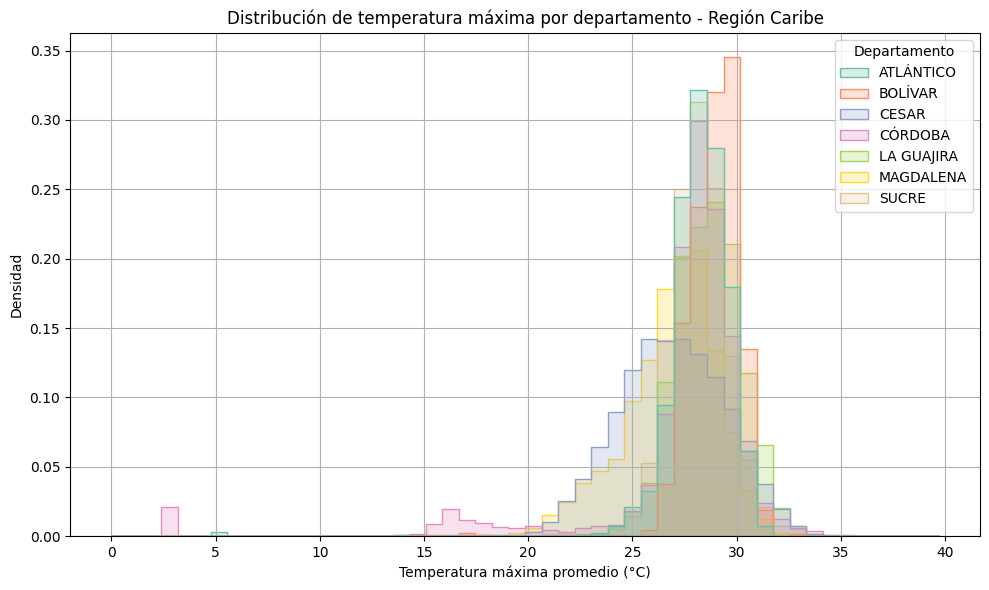

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarnos de tener los datos
# df_departamento debe tener las columnas: Departamento, Fecha, ValorObservado

plt.figure(figsize=(10, 6))

# Crear el histograma combinado
sns.histplot(data=df_departamento, 
             x="ValorObservado", 
             hue="Departamento", 
             element="step", 
             stat="density", 
             common_norm=False, 
             bins=50,
             palette="Set2")

plt.title("Distribución de temperatura máxima por departamento - Región Caribe")
plt.xlabel("Temperatura máxima promedio (°C)")
plt.ylabel("Densidad")
plt.grid(True)
plt.tight_layout()
plt.show()



## Tratamiento datos atipicos

In [14]:
# Creamos una copia para no alterar el original
df_filtrado = df_departamento.copy()

# Función para quitar outliers usando IQR por departamento
def eliminar_outliers_iqr(grupo):
    Q1 = grupo['ValorObservado'].quantile(0.25)
    Q3 = grupo['ValorObservado'].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return grupo[(grupo['ValorObservado'] >= lim_inf) & (grupo['ValorObservado'] <= lim_sup)]

# Aplicar por departamento
df_filtrado = df_filtrado.groupby('Departamento').apply(eliminar_outliers_iqr).reset_index(drop=True)


C:\Users\mathe\AppData\Local\Temp\ipykernel_7128\2705949866.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtrado = df_filtrado.groupby('Departamento').apply(eliminar_outliers_iqr).reset_index(drop=True)


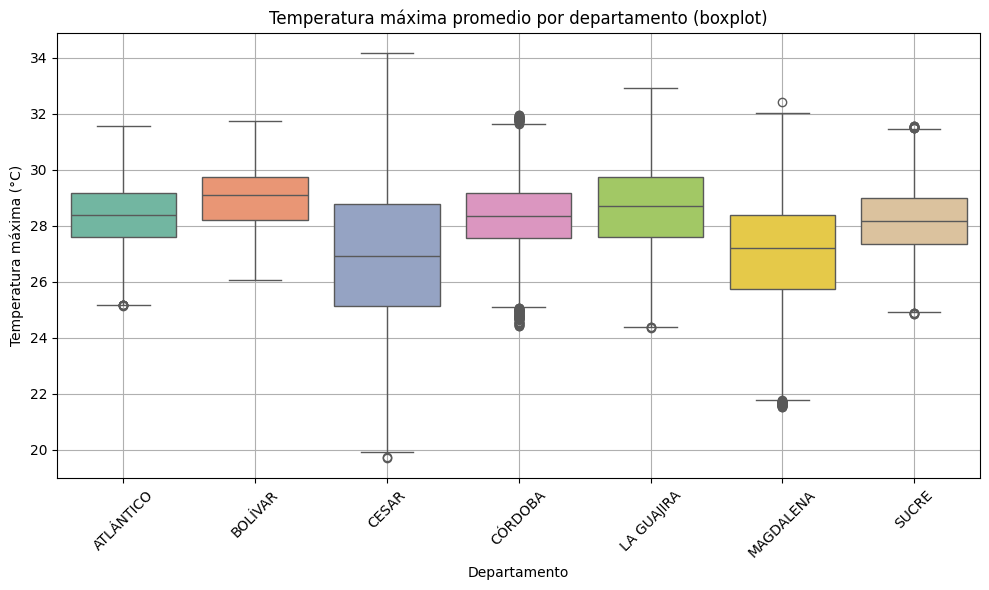

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_filtrado,
    x="Departamento",
    y="ValorObservado",
    hue="Departamento",    
    palette="Set2",
    legend=False            
)
plt.title("Temperatura máxima promedio por departamento (boxplot)")
plt.xlabel("Departamento")
plt.ylabel("Temperatura máxima (°C)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Evolucion temporal por departamento

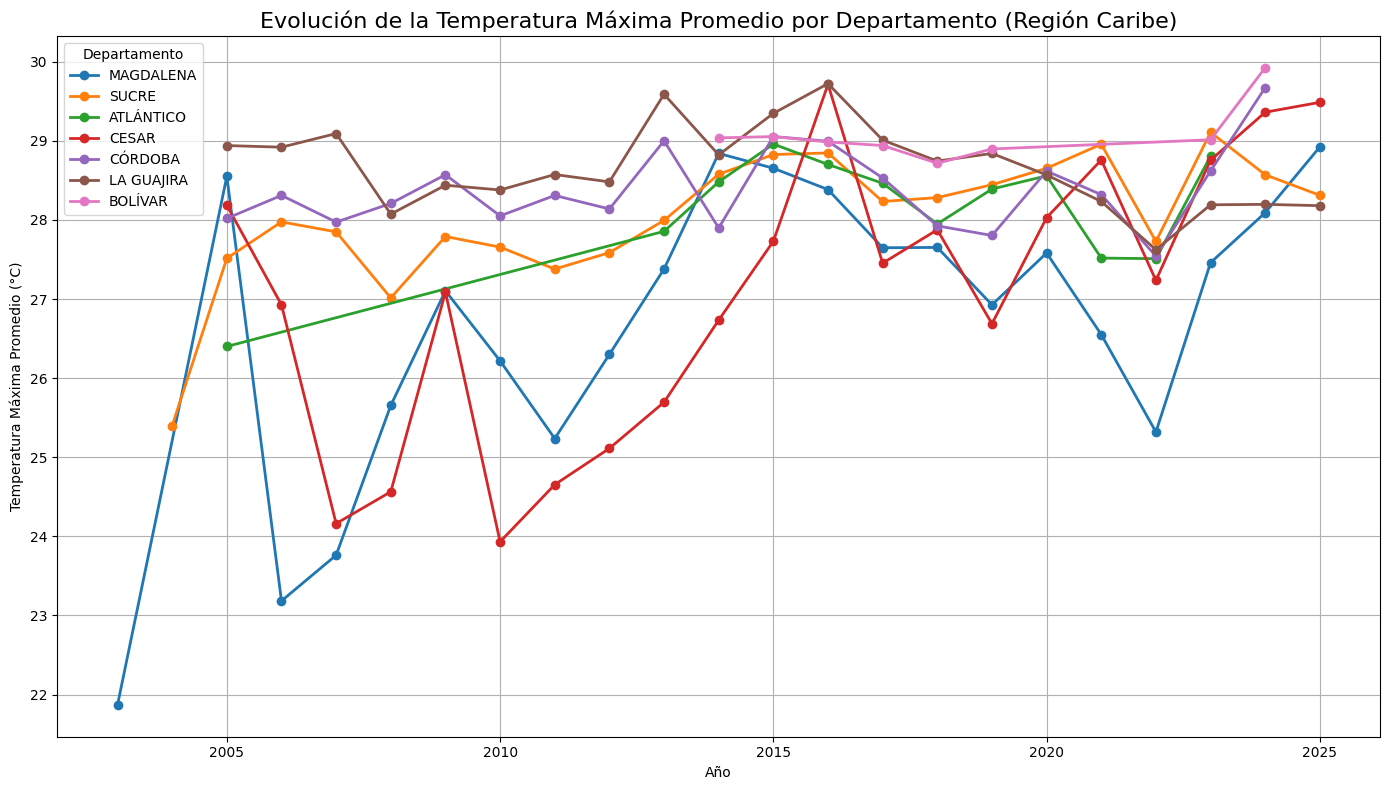

In [8]:
import matplotlib.pyplot as plt

# Obtener los datos agrupados por año y departamento
df_lineas = df_filtrado.groupby(['Año', 'Departamento'])['ValorObservado'].mean().reset_index()

# Lista de departamentos únicos
departamentos = df_lineas['Departamento'].unique()

# Crear figura
plt.figure(figsize=(14, 8))

# Graficar una línea por departamento
for depto in departamentos:
    datos_depto = df_lineas[df_lineas['Departamento'] == depto]
    plt.plot(
        datos_depto['Año'],
        datos_depto['ValorObservado'],
        label=depto,
        marker='o',
        linewidth=2
    )

# Personalización del gráfico
plt.title('Evolución de la Temperatura Máxima Promedio por Departamento (Región Caribe)', fontsize=16)
plt.xlabel('Año')
plt.ylabel('Temperatura Máxima Promedio (°C)')
plt.legend(title='Departamento')
plt.grid(True)
plt.tight_layout()
plt.show()


## Resultados del Ajuste Polinómico por Departamento

Para estudiar la evolución de la temperatura máxima promedio en los departamentos de la región Caribe, se realizó un ajuste polinómico de segundo, tercer y cuarto grado para cada uno, evaluando la calidad del ajuste mediante el coeficiente de determinación \( R^2 \).

A continuación, se presentan los gráficos con los datos reales y las curvas ajustadas, organizados por subgráficos:

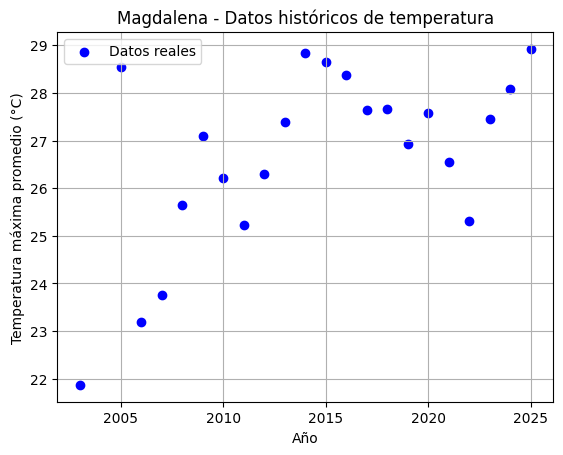

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que estos son tus datos ya filtrados:
df_magdalena = df_filtrado[df_filtrado["Departamento"] == "MAGDALENA"]
df_mag = df_magdalena.groupby("Año")["ValorObservado"].mean().reset_index()

x = df_mag["Año"].values
y = df_mag["ValorObservado"].values

# Visualizar datos
plt.scatter(x, y, color='blue', label="Datos reales")
plt.xlabel("Año")
plt.ylabel("Temperatura máxima promedio (°C)")
plt.title("Magdalena - Datos históricos de temperatura")
plt.grid(True)
plt.legend()
plt.show()

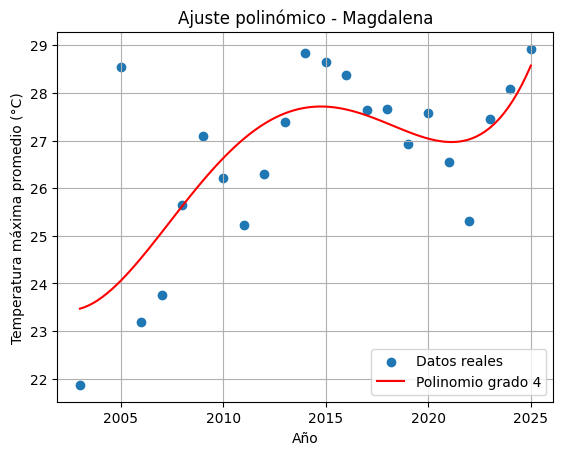

Coeficiente de determinación R²: 0.491


In [ ]:
from sklearn.metrics import r2_score

grado = 4
coeficientes = np.polyfit(x, y, grado)

# Crear la función polinómica ajustada
polinomio = np.poly1d(coeficientes)

# Crear puntos para graficar la curva suavemente
x_fit = np.linspace(min(x), max(x), 100)
y_fit = polinomio(x_fit)

# Graficar curva ajustada
plt.scatter(x, y, label="Datos reales")
plt.plot(x_fit, y_fit, color='red', label=f"Polinomio grado {grado}")
plt.xlabel("Año")
plt.ylabel("Temperatura máxima promedio (°C)")
plt.title("Ajuste polinómico - Magdalena")
plt.legend()
plt.grid(True)
plt.show()

y_pred = polinomio(x)
r2 = r2_score(y, y_pred)
print(f"Coeficiente de determinación R²: {r2:.3f}")

 Atlántico: Mejor ajuste con polinomio de grado 4, R² = 0.795
 Bolívar: Mejor ajuste con polinomio de grado 4, R² = 0.945
 Cesar: Mejor ajuste con polinomio de grado 4, R² = 0.719
 Córdoba: Mejor ajuste con polinomio de grado 4, R² = 0.412
 La Guajira: Mejor ajuste con polinomio de grado 4, R² = 0.643
 Magdalena: Mejor ajuste con polinomio de grado 4, R² = 0.491
 Sucre: Mejor ajuste con polinomio de grado 4, R² = 0.619


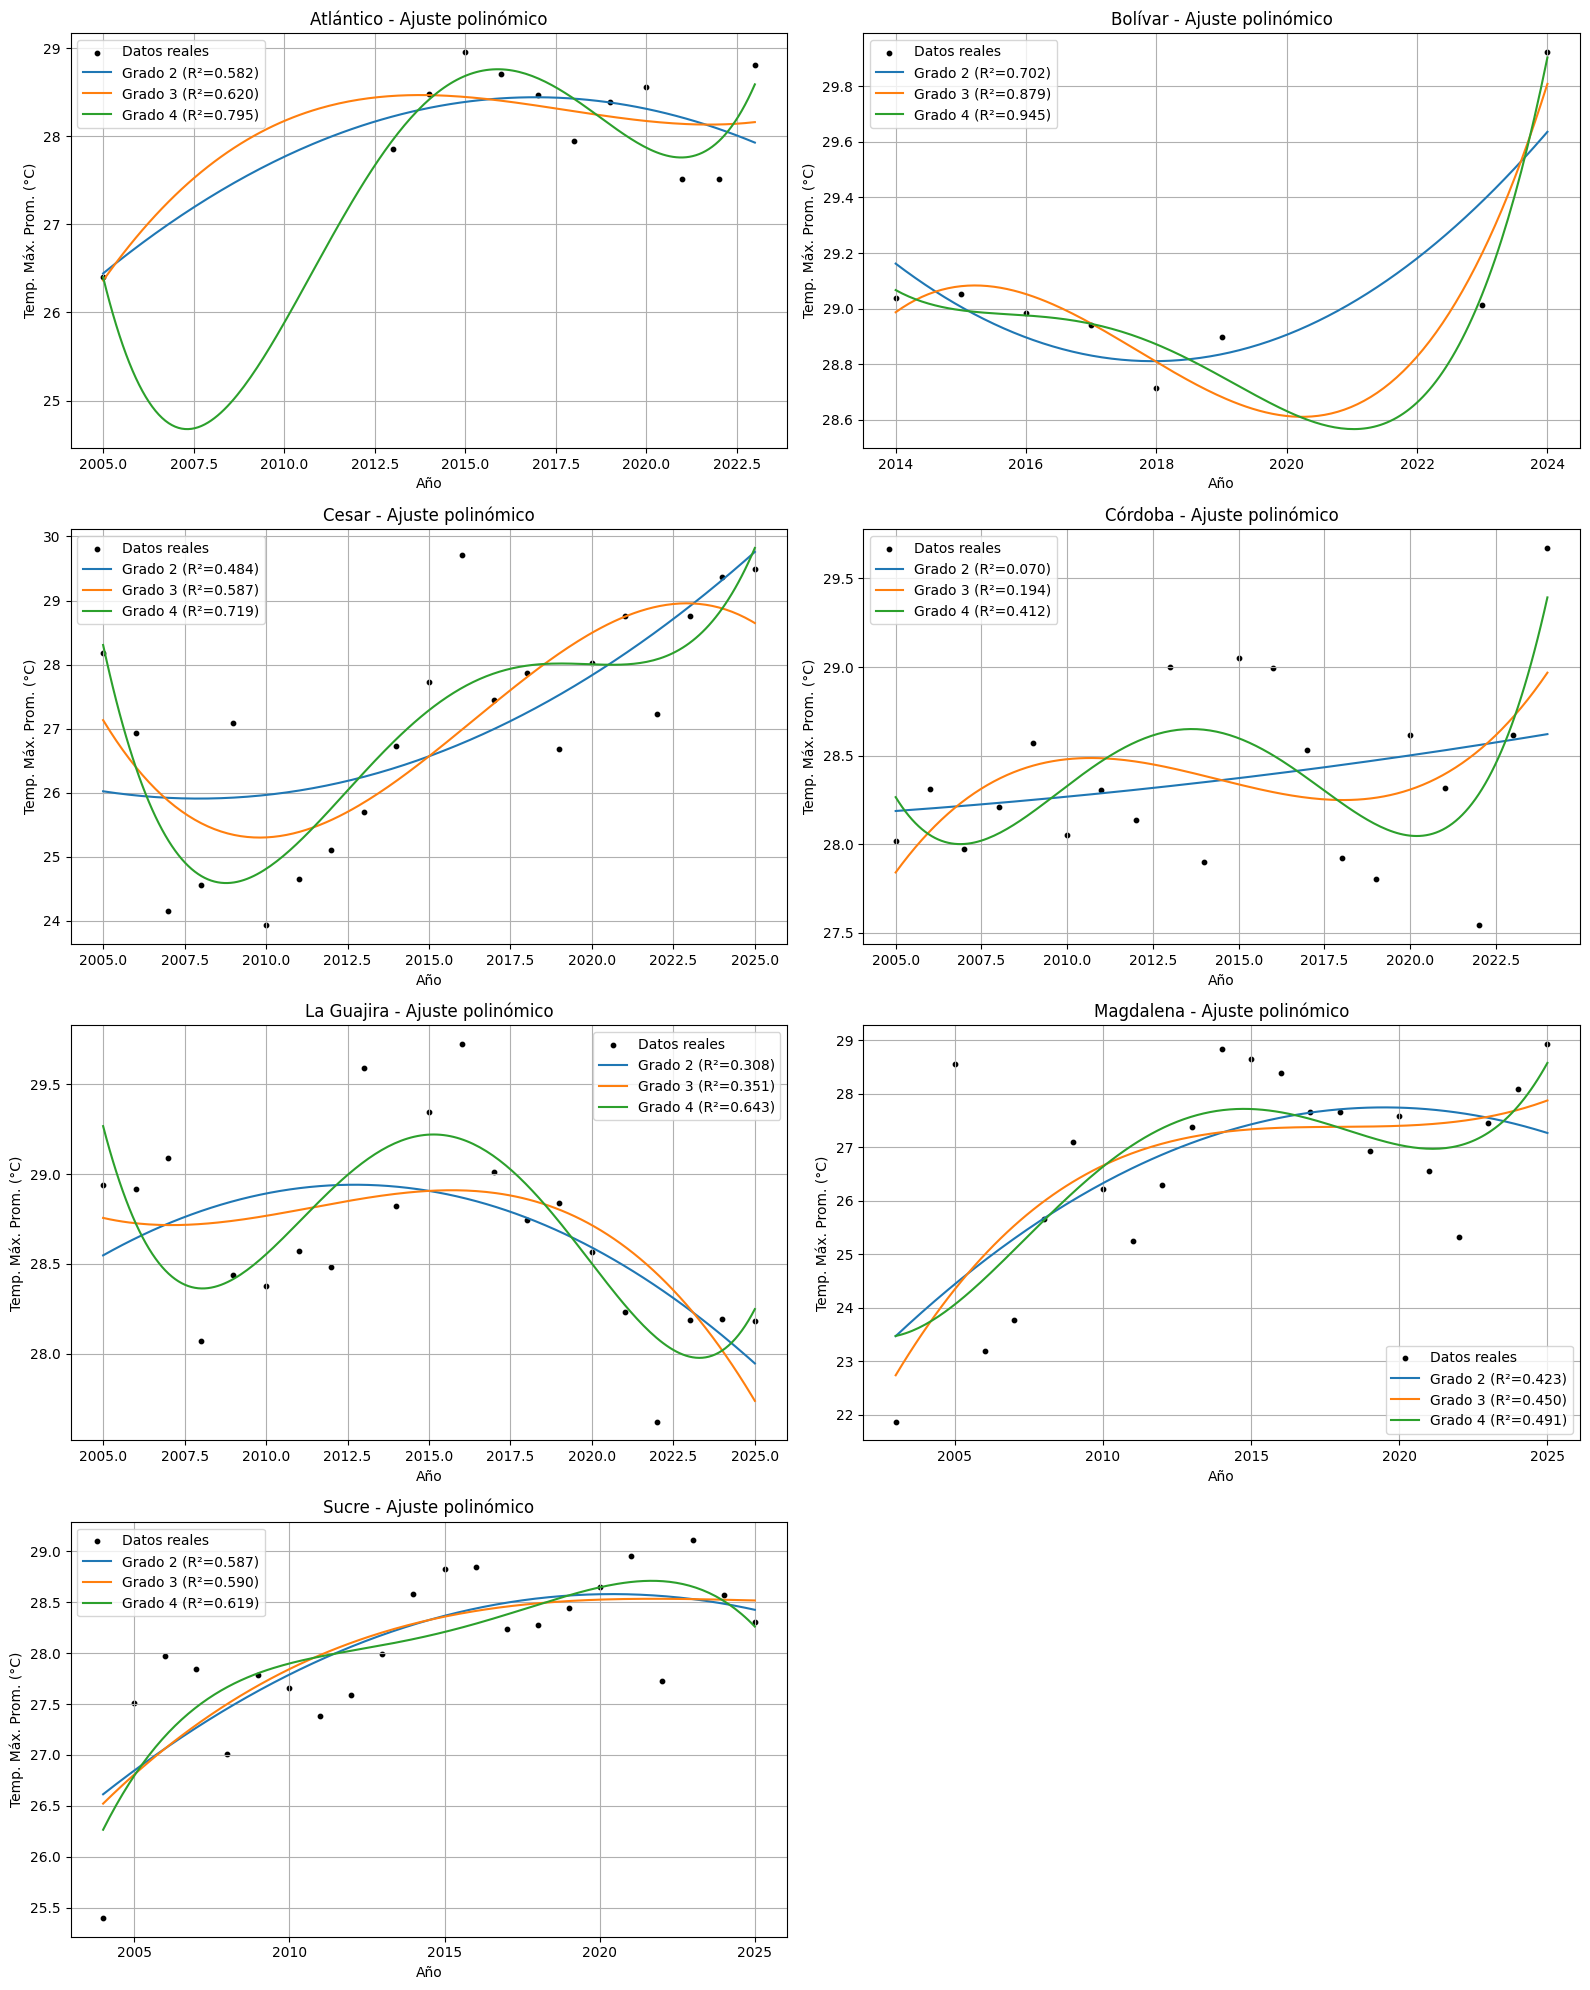

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

grados = [2, 3, 4]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()

for i, depto in enumerate(departamentos_caribe):
    datos = df_filtrado[df_filtrado['Departamento'] == depto]
    dat = datos.groupby("Año")["ValorObservado"].mean().reset_index()
    x = dat['Año'].values
    y = dat['ValorObservado'].values

    ax = axes[i]
    ax.scatter(x, y, color='black', label='Datos reales', s=10)

    mejores_r2 = 0
    mejor_grado = 0

    for grado in [2, 3, 4]:
        coef = np.polyfit(x, y, deg=grado)
        poly = np.poly1d(coef)
        y_pred = poly(x)

        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        if r2 > mejores_r2:
            mejores_r2 = r2
            mejor_grado = grado

        x_fit = np.linspace(x.min(), x.max(), 200)
        y_fit = poly(x_fit)
        ax.plot(x_fit, y_fit, label=f'Grado {grado} (R²={r2:.3f})')

    ax.set_title(f"{depto.title()} - Ajuste polinómico")
    ax.set_xlabel("Año")
    ax.set_ylabel("Temp. Máx. Prom. (°C)")
    ax.legend()
    ax.grid(True)

    print(f" {depto.title()}: Mejor ajuste con polinomio de grado {mejor_grado}, R² = {mejores_r2:.3f}")

fig.delaxes(axes[-1])  
plt.tight_layout()
plt.show()

### 🧾 Comentarios por Departamento

| Departamento | Mejor grado | \( R^2 \) | Observaciones |
|--------------|-------------|-----------|----------------|
| Atlántico    | 4           | 0.795     | Buen ajuste; la tendencia polinómica captura adecuadamente las variaciones. |
| Bolívar      | 4           | 0.945     | Ajuste excelente; el modelo explica gran parte de la variabilidad observada. |
| Cesar        | 4           | 0.719     | Ajuste notable; el modelo representa bien la tendencia general. |
| Córdoba      | 4           | 0.412     | Ajuste moderado; el modelo muestra cierta capacidad explicativa. |
| La Guajira   | 4           | 0.643     | Ajuste razonable; se observa una tendencia clara a lo largo del tiempo. |
| Magdalena    | 4           | 0.491     | Ajuste aceptable; el modelo se adapta parcialmente a la variabilidad. |
| Sucre        | 4           | 0.619     | Buen ajuste relativo; mejora considerable respecto a los datos sin filtrar. |

###  Interpretación general

- El filtrado de valores atípicos tuvo un **impacto significativo** en el desempeño del modelo polinómico, mejorando notablemente los coeficientes \( R^2 \).
- En la mayoría de los casos, un polinomio de grado 4 permite **representar de forma aceptable la tendencia histórica** de la temperatura máxima promedio anual.
- Sin embargo, debido a que los modelos polinómicos pueden sobreajustarse y generar **proyecciones poco realistas**, se recomienda complementarlos o compararlos con enfoques como **splines cúbicos** o modelos de series temporales más robustos (como Prophet).


### Proyección de temperatura máxima promedio mediante regresión polinómica

Con el objetivo de estimar la evolución futura de la temperatura máxima promedio en los departamentos de la región Caribe, se empleó un modelo de regresión polinómica ajustado a los datos históricos de temperatura. Para cada departamento se exploraron polinomios de grado 2, 3 y 4, y se seleccionó el modelo con el mejor coeficiente de determinación R2R2.

Una vez determinado el mejor ajuste para cada caso, se utilizó dicho modelo para realizar proyecciones hasta el año 2030. Estas proyecciones permiten visualizar una posible tendencia futura en el comportamiento térmico de la región.

En los gráficos generados:

    Los puntos negros representan los valores reales observados.

    Las curvas sólidas de colores representan los distintos ajustes polinómicos evaluados.

    La línea roja punteada muestra la proyección estimada por el modelo polinómico con mejor ajuste.

Este análisis permite anticipar posibles escenarios de aumento o estabilización de la temperatura, aportando información clave para el monitoreo del cambio climático a nivel regional.

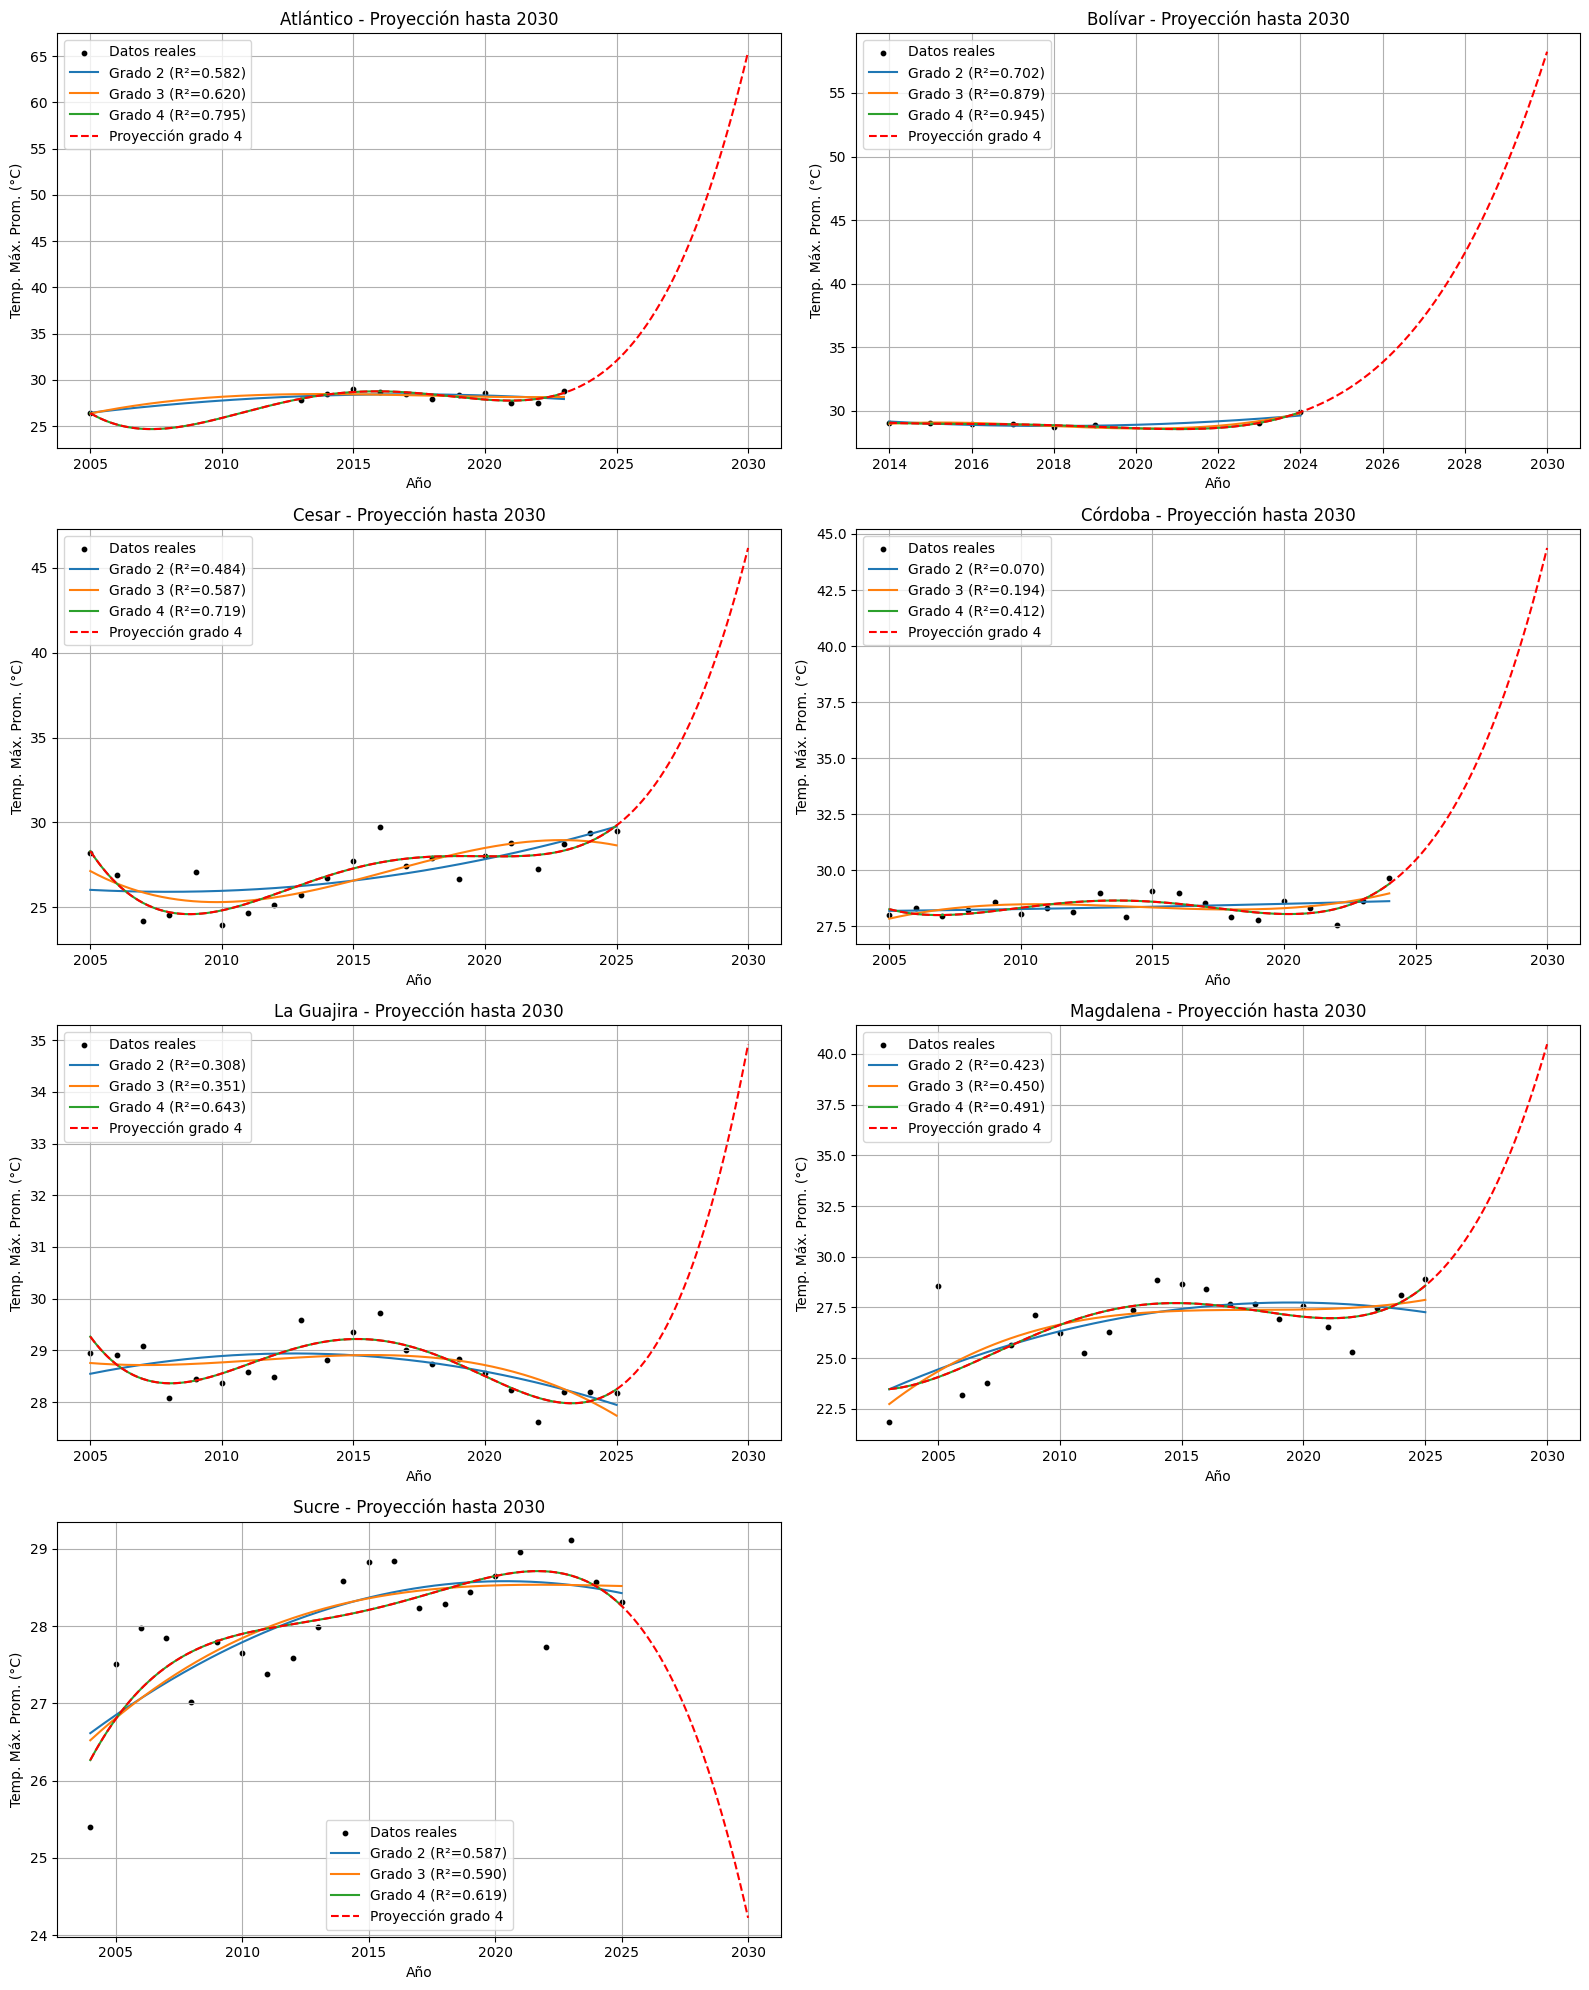

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

grados = [2, 3, 4]
anio_proyeccion = 2030 

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()

for i, depto in enumerate(departamentos_caribe):
    datos = df_filtrado[df_filtrado['Departamento'] == depto]
    dat = datos.groupby("Año")["ValorObservado"].mean().reset_index()
    x = dat['Año'].values
    y = dat['ValorObservado'].values

    ax = axes[i]
    ax.scatter(x, y, color='black', label='Datos reales', s=10)

    mejores_r2 = 0
    mejor_grado = 0
    mejor_poly = None

    for grado in grados:
        coef = np.polyfit(x, y, deg=grado)
        poly = np.poly1d(coef)
        y_pred = poly(x)

        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        if r2 > mejores_r2:
            mejores_r2 = r2
            mejor_grado = grado
            mejor_poly = poly

        x_fit = np.linspace(x.min(), x.max(), 200)
        y_fit = poly(x_fit)
        ax.plot(x_fit, y_fit, label=f'Grado {grado} (R²={r2:.3f})')

    # Proyección hacia el futuro con el mejor polinomio
    x_proj = np.linspace(x.min(), anio_proyeccion, 300)
    y_proj = mejor_poly(x_proj)
    ax.plot(x_proj, y_proj, '--', color='red', label=f'Proyección grado {mejor_grado}')

    ax.set_title(f"{depto.title()} - Proyección hasta {anio_proyeccion}")
    ax.set_xlabel("Año")
    ax.set_ylabel("Temp. Máx. Prom. (°C)")
    ax.legend()
    ax.grid(True)

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()


## Resultados de Spline cubico por Departamento

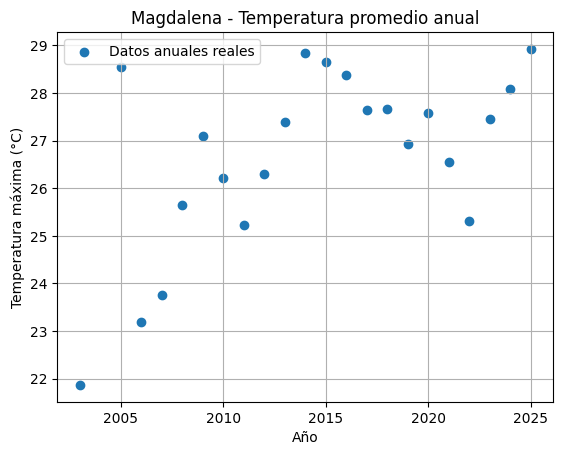

In [ ]:
from scipy.interpolate import CubicSpline

df_mag = df_magdalena.groupby("Año")["ValorObservado"].mean().reset_index()

x_spline = df_mag["Año"].values
y_spline = df_mag["ValorObservado"].values

# Visualización básica
plt.scatter(x_spline, y_spline, label="Datos anuales reales")
plt.xlabel("Año")
plt.ylabel("Temperatura máxima (°C)")
plt.title("Magdalena - Temperatura promedio anual")
plt.grid(True)
plt.legend()
plt.show()


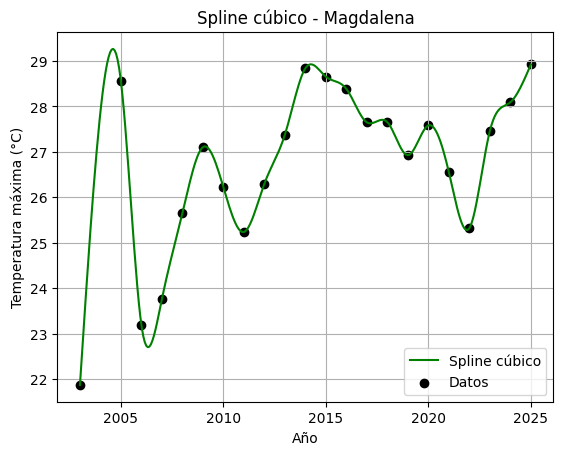

In [24]:
# Crear el spline cúbico
spline = CubicSpline(x_spline, y_spline, bc_type='natural')

# Crear puntos densos para graficar la curva suavemente
x_denso = np.linspace(min(x_spline), max(x_spline), 300)
y_denso = spline(x_denso)

# Graficar spline
plt.plot(x_denso, y_denso, color='green', label="Spline cúbico")
plt.scatter(x_spline, y_spline, color='black', label="Datos")
plt.xlabel("Año")
plt.ylabel("Temperatura máxima (°C)")
plt.title("Spline cúbico - Magdalena")
plt.legend()
plt.grid(True)
plt.show()


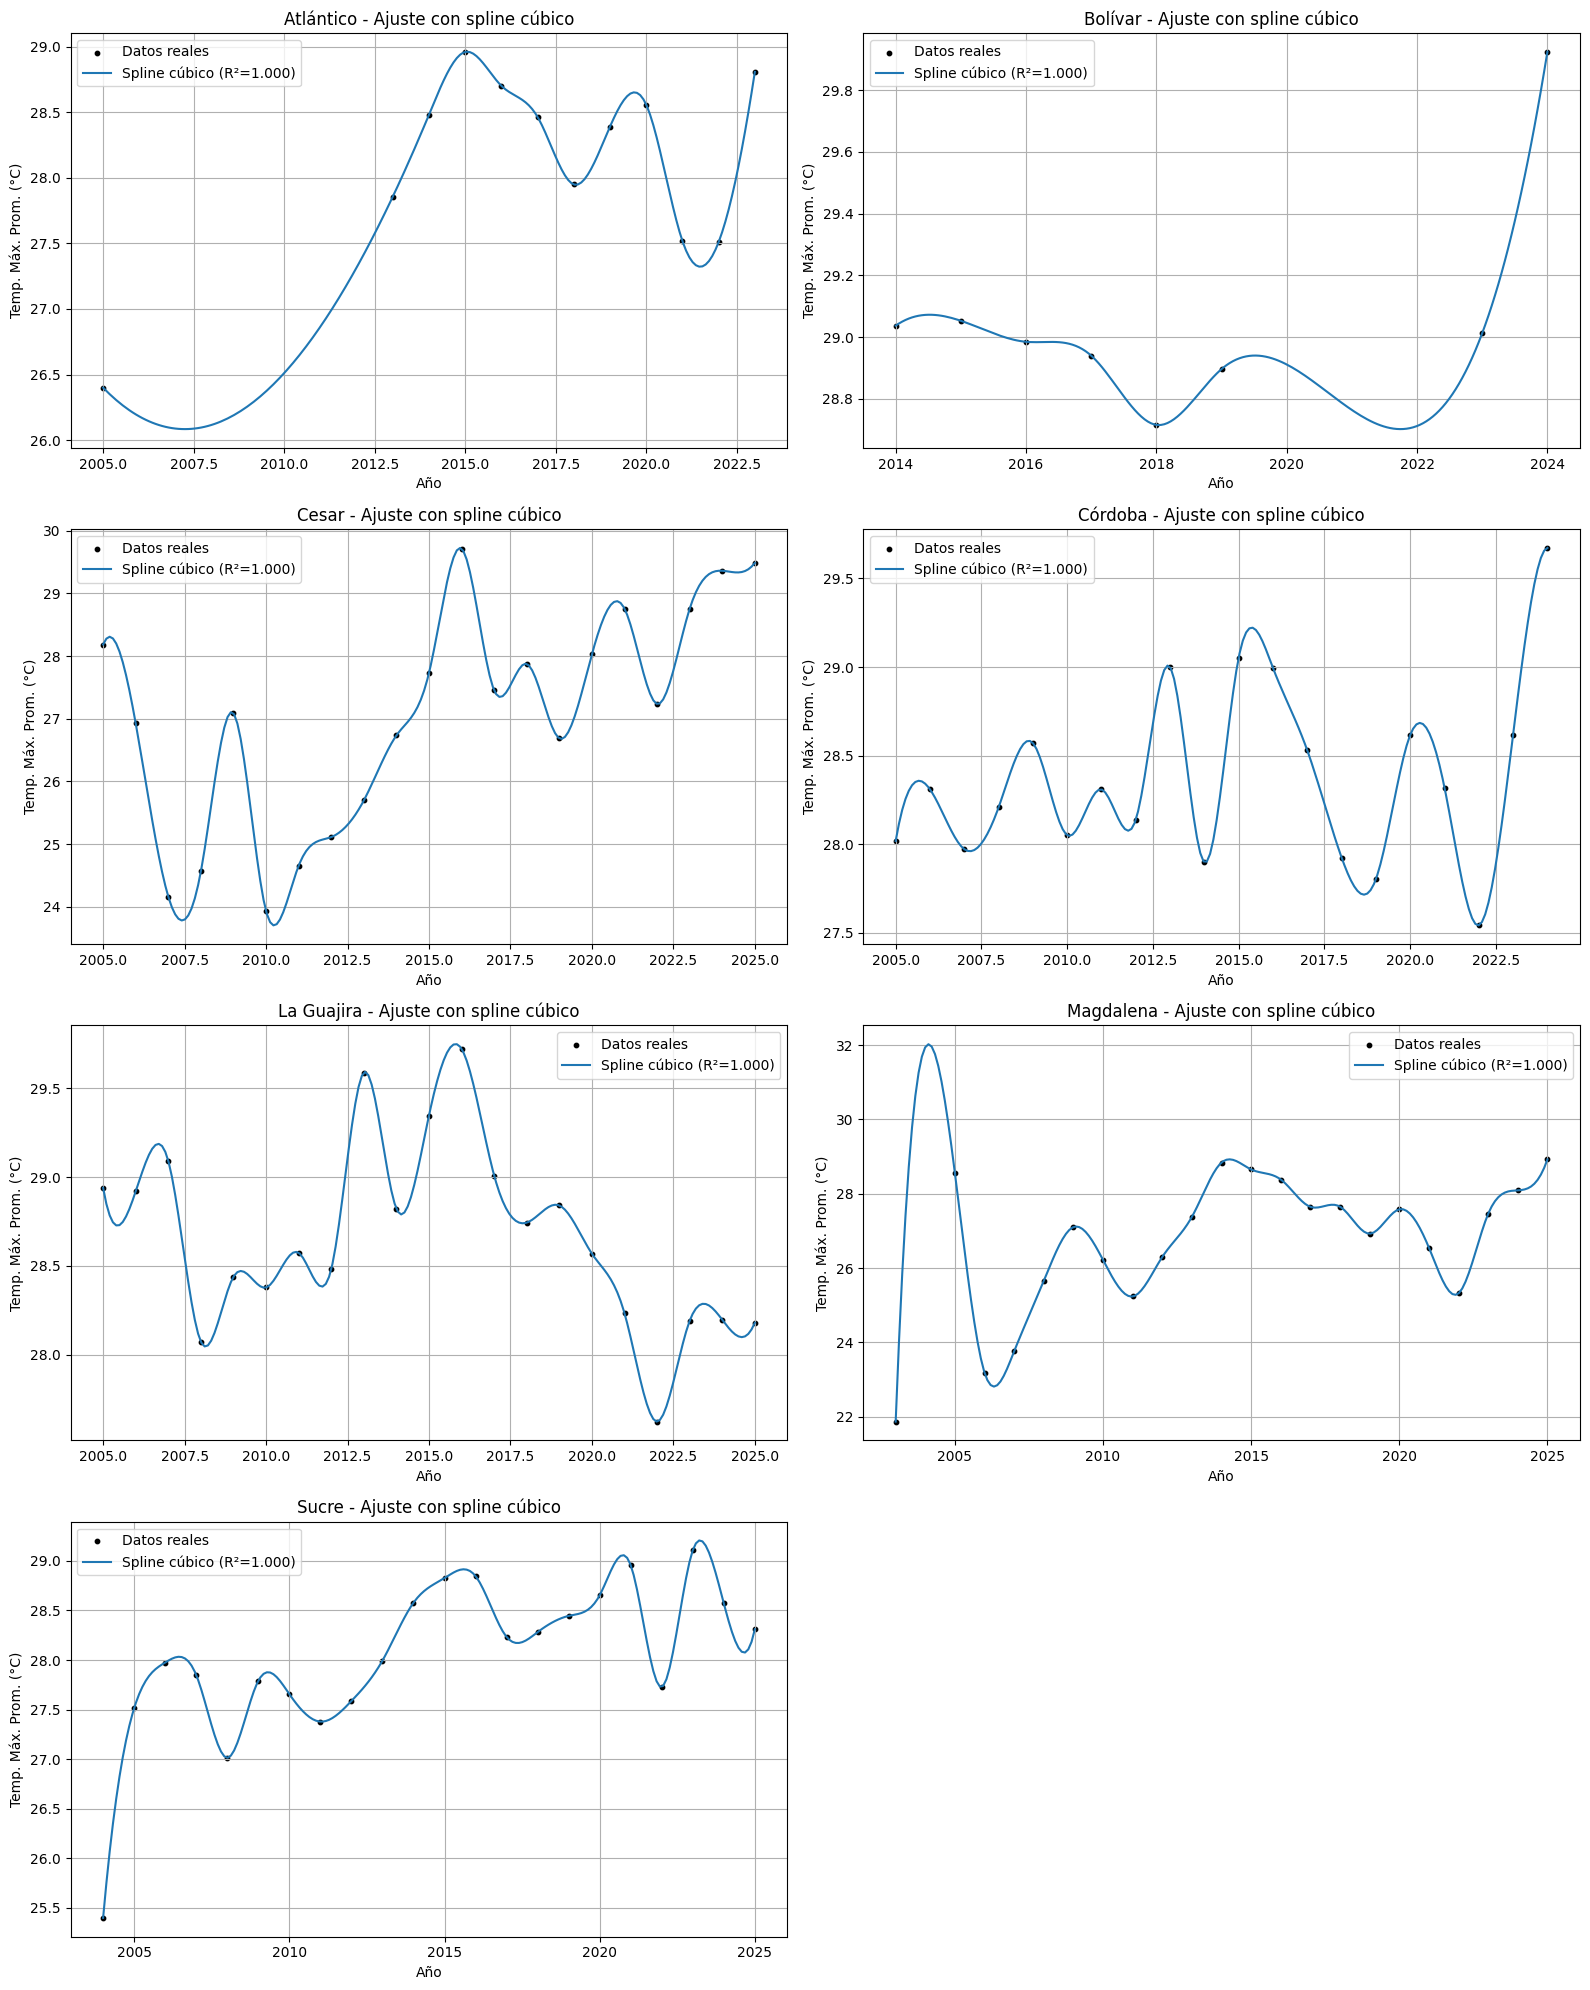

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()

for i, depto in enumerate(departamentos_caribe):
    datos = df_filtrado[df_filtrado['Departamento'] == depto]
    dat = datos.groupby("Año")["ValorObservado"].mean().reset_index()
    x = dat['Año'].values
    y = dat['ValorObservado'].values

    ax = axes[i]
    ax.scatter(x, y, color='black', label='Datos reales', s=10)

    # Ajuste spline cúbico
    spline = CubicSpline(x, y)
    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = spline(x_fit)

    # Cálculo de R² manual para spline
    y_pred = spline(x)
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    ax.plot(x_fit, y_fit, color='tab:blue', label=f'Spline cúbico (R²={r2:.3f})')

    ax.set_title(f"{depto.title()} - Ajuste con spline cúbico")
    ax.set_xlabel("Año")
    ax.set_ylabel("Temp. Máx. Prom. (°C)")
    ax.legend()
    ax.grid(True)

# Eliminar subplot vacío si hay menos de 8 departamentos
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()


### Proyección de temperatura máxima promedio mediante interpolación por splines cúbicos

Además del enfoque de regresión polinómica, se implementó una técnica de interpolación basada en splines cúbicos para modelar y proyectar la evolución de la temperatura máxima promedio en los departamentos de la región Caribe.

Los splines cúbicos son funciones a trozos que aseguran suavidad y continuidad hasta la segunda derivada, lo que los convierte en una herramienta eficaz para modelar datos con comportamientos no lineales o fluctuaciones locales.
Metodología:

    Se utilizó la temperatura máxima promedio anual por departamento.

    Se ajustó un spline cúbico a los datos históricos de cada departamento.

    A partir del spline obtenido, se realizó una extrapolación para estimar valores futuros hasta el año 2030.

Resultados:

    Los datos reales se representan con puntos negros.

    La curva azul continua muestra el spline cúbico ajustado.

    La línea punteada a partir del año 2023 corresponde a la proyección realizada con dicho modelo.

Este enfoque ofrece una representación más flexible en comparación con los polinomios de alto grado, especialmente útil cuando se desea evitar oscilaciones excesivas o comportamientos erráticos fuera del rango de datos conocidos.

Sin embargo, es importante tener en cuenta que la extrapolación con splines fuera del intervalo de datos originales puede ser menos confiable, ya que su comportamiento está fuertemente condicionado por la información disponible dentro del intervalo de ajuste.

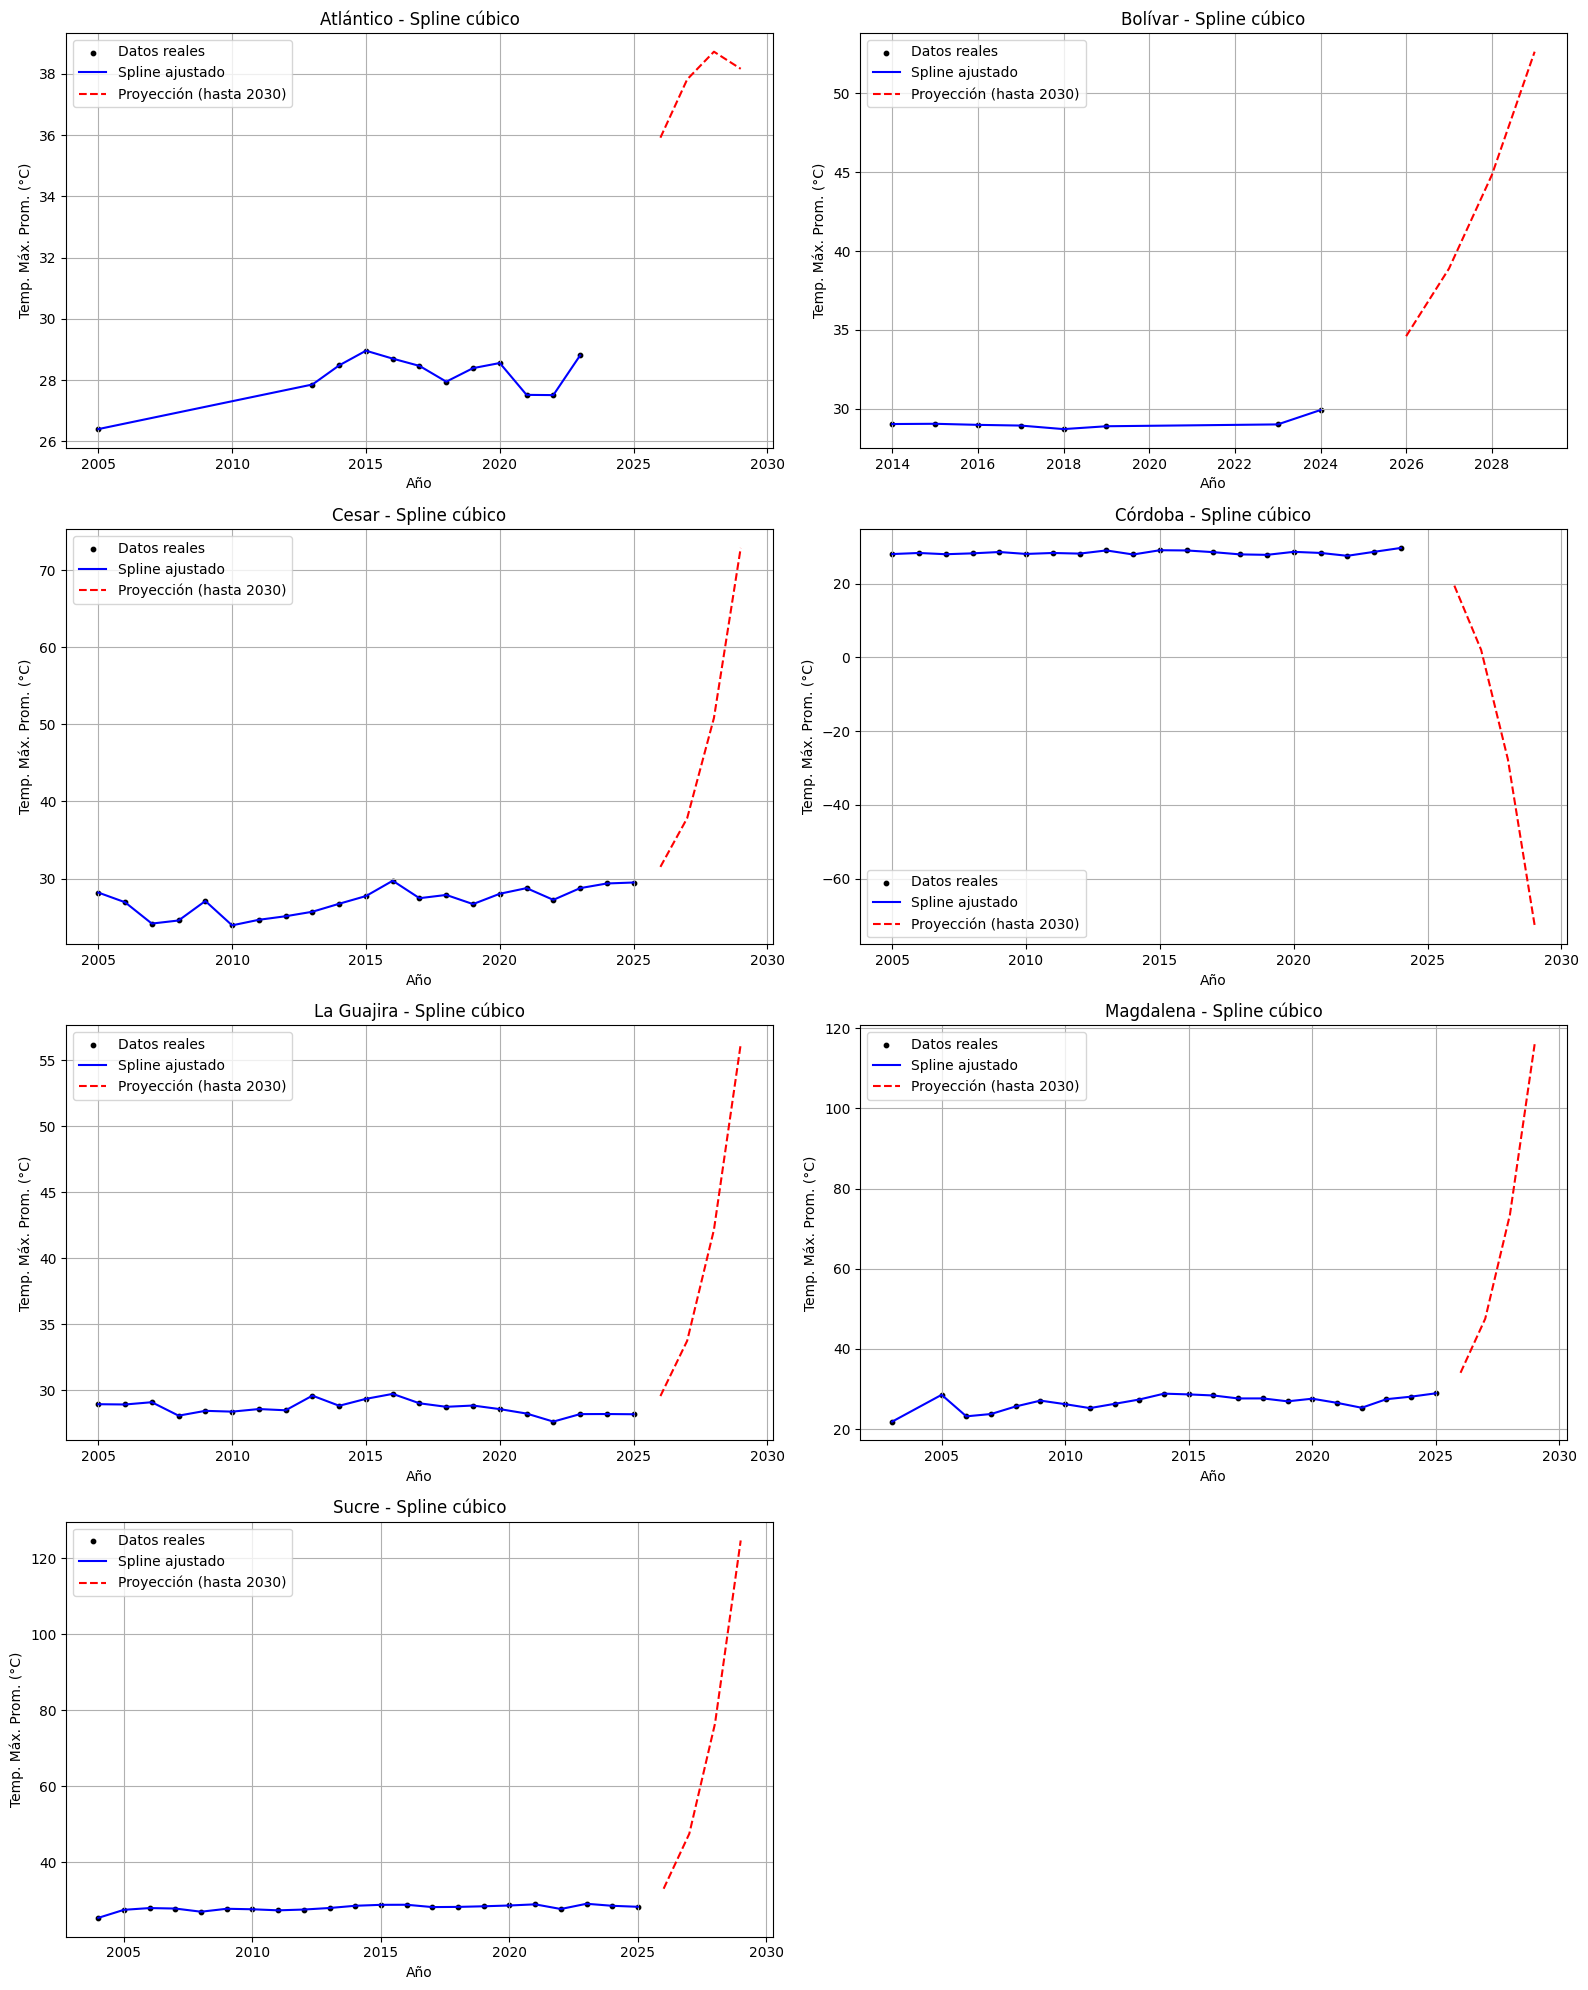

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Lista de departamentos del Caribe
departamentos_caribe = df_filtrado["Departamento"].unique()

# Proyección hasta 2035
año_max = df_filtrado["Año"].max()
años_futuros = np.arange(año_max + 1, 2030)

# Crear gráfico
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()

for i, depto in enumerate(departamentos_caribe):
    datos = df_filtrado[df_filtrado["Departamento"] == depto]
    dat = datos.groupby("Año")["ValorObservado"].mean().reset_index()
    x = dat["Año"].values
    y = dat["ValorObservado"].values

    # Ajuste de spline cúbico
    spline = CubicSpline(x, y, extrapolate=True)

    # Rango completo de años: históricos + futuros
    x_total = np.concatenate([x, años_futuros])
    y_total = spline(x_total)

    ax = axes[i]
    # Datos originales
    ax.scatter(x, y, color='black', label="Datos reales", s=10)

    # Línea spline ajustada
    ax.plot(x, spline(x), color='blue', label="Spline ajustado")

    # Proyección futura
    ax.plot(años_futuros, spline(años_futuros), 'r--', label="Proyección (hasta 2030)")

    ax.set_title(f"{depto.title()} - Spline cúbico")
    ax.set_xlabel("Año")
    ax.set_ylabel("Temp. Máx. Prom. (°C)")
    ax.grid(True)
    ax.legend()

if len(departamentos_caribe) < len(axes):
    for j in range(len(departamentos_caribe), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Resultados usando el modelo prophet